**Load Dataset**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Install kaggle library
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"smmmmmmmm","key":"7b133f9532960b035175029dd9cafb37"}'}

In [ ]:
# Move kaggle.json to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip telco-customer-churn.zip

Archive:  telco-customer-churn.zip
replace WA_Fn-UseC_-Telco-Customer-Churn.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Basic information about the dataset
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Data Cleaning**

In [ ]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Convert 'TotalCharges' to numeric (some values are blank, causing errors)
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")
# Drop rows with missing TotalCharges
data.dropna(inplace=True)

# Drop 'customerID' as it is not useful for modeling
data = data.drop(columns=["customerID"])

# Encode categorical variables using LabelEncoder
encoder = LabelEncoder()
for column in data.select_dtypes(include="object").columns:
    if column != "Churn":
        data[column] = encoder.fit_transform(data[column])

# Convert 'Churn' into binary format (Yes = 1, No = 0)
data["Churn"] = data["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]
data[numerical_features] = scaler.fit_transform(data[numerical_features])


Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


**Exploratory Data Analysis**


---


Churn Distribution

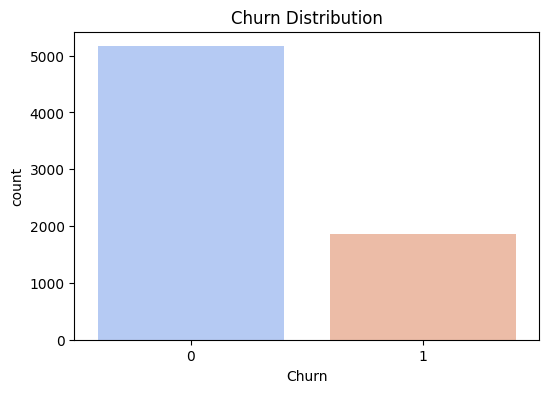


Churn Percentage:
Churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Churn", data=data, palette="coolwarm")
plt.title("Churn Distribution")
plt.show()

churn_percent = data['Churn'].value_counts(normalize=True) * 100
print("\nChurn Percentage:")
print(churn_percent)

Churn by Contract Type

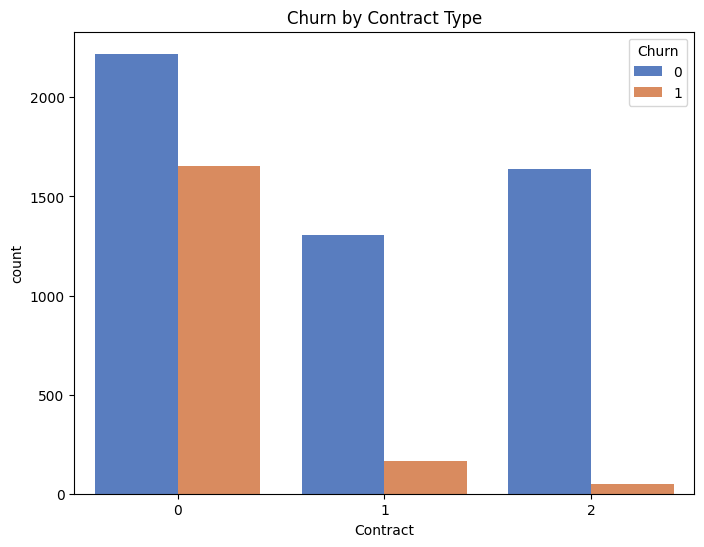


Churn Rate by Contract Type:
Contract
0    42.709677
1    11.277174
2     2.848665
Name: Churn, dtype: float64


In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x="Contract", hue="Churn", data=data, palette="muted")
plt.title("Churn by Contract Type")
plt.show()


# Calculate churn rate by contract type
churn_by_contract = data.groupby("Contract")["Churn"].mean() * 100
print("\nChurn Rate by Contract Type:")
print(churn_by_contract)

Monthly Charges Distribution

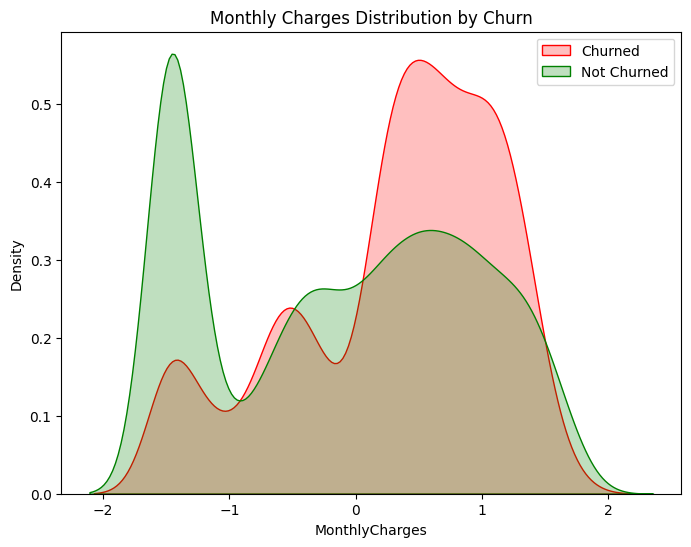

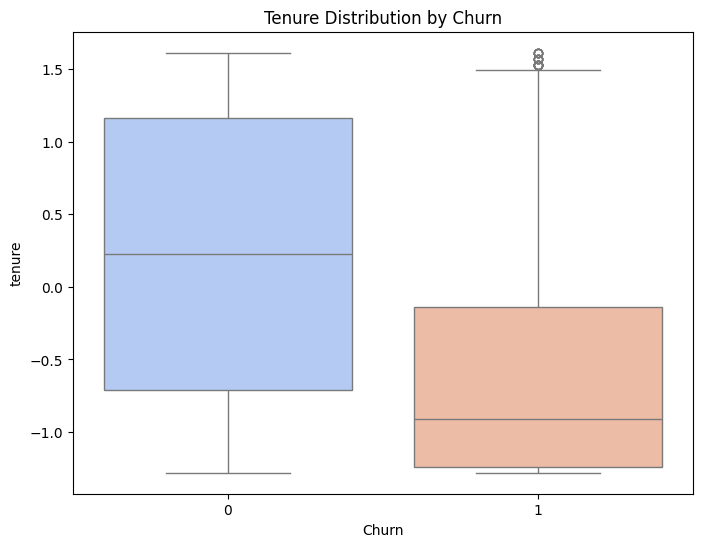

In [ ]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=data[data["Churn"] == 1], x="MonthlyCharges", fill=True, color="red", label="Churned")
sns.kdeplot(data=data[data["Churn"] == 0], x="MonthlyCharges", fill=True, color="green", label="Not Churned")
plt.title("Monthly Charges Distribution by Churn")
plt.legend()
plt.show()

# Compare tenure between churned and non-churned
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x="Churn", y="tenure", palette="coolwarm")
plt.title("Tenure Distribution by Churn")
plt.show()


**Machine Learning Models**


---


Data Preprocessing

In [ ]:
# Encode categorical features
categorical_cols = data.select_dtypes(include="object").columns
encoder = LabelEncoder()

for col in categorical_cols:
    if col != "Churn":
        data[col] = encoder.fit_transform(data[col])

# Standardize numerical features
scaler = StandardScaler()
data[["tenure", "MonthlyCharges", "TotalCharges"]] = scaler.fit_transform(data[["tenure", "MonthlyCharges", "TotalCharges"]])


Model Training


In [ ]:
X = data.drop("Churn", axis=1)
y = data["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)


Accuracy: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.61      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407



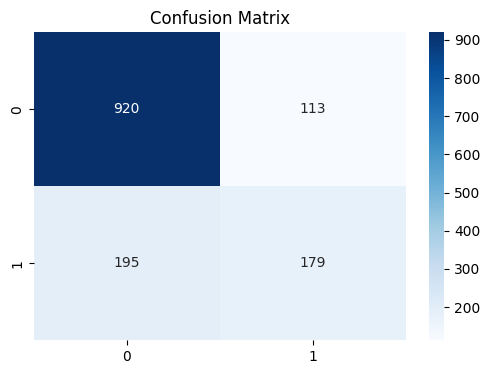

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


Feature Importance

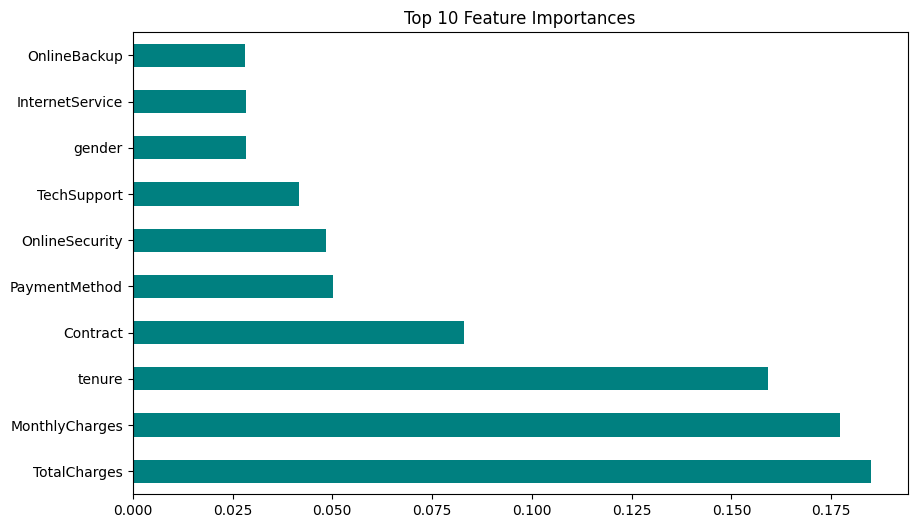

In [ ]:
# Feature Importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.head(10).plot(kind="barh", color="teal")
plt.title("Top 10 Feature Importances")
plt.show()


Feature importance shows that tenure and monthly charges are the strongest predictors.

Hyperparameter Tuning

In [ ]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

xgb_model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


**Forecasting**

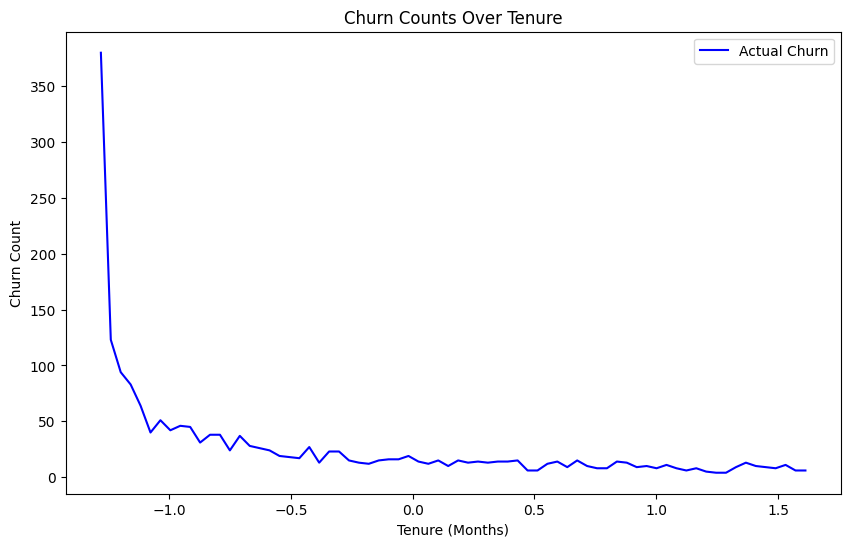

In [ ]:
churn_over_time = data.groupby("tenure")["Churn"].sum().reset_index()

# Plot churn over tenure
plt.figure(figsize=(10, 6))
plt.plot(churn_over_time["tenure"], churn_over_time["Churn"], label="Actual Churn", color="blue")
plt.title("Churn Counts Over Tenure")
plt.xlabel("Tenure (Months)")
plt.ylabel("Churn Count")
plt.legend()
plt.show()


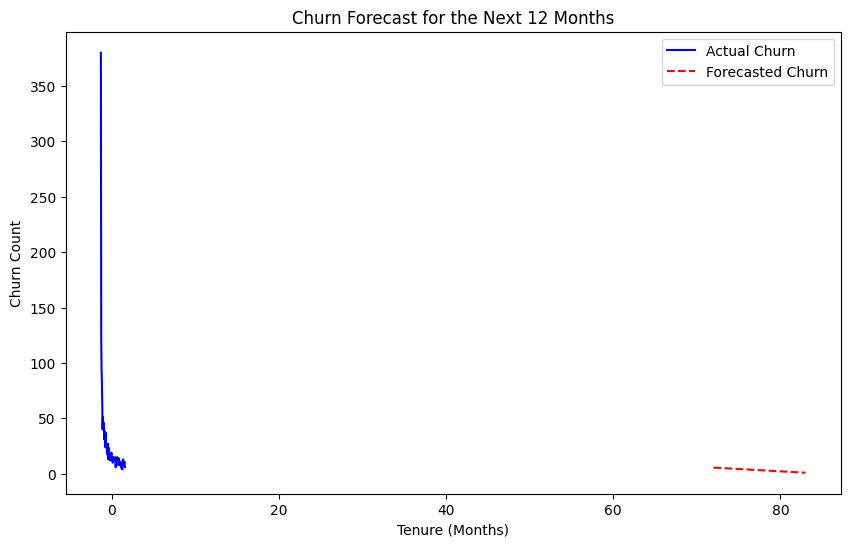

In [ ]:
# Fit the model
model_forecast = ExponentialSmoothing(churn_over_time["Churn"], trend="add", seasonal=None)
forecast = model_forecast.fit()

# Forecast for the next 12 months
future_churn = forecast.forecast(12)

# Plot actual and forecasted churn
plt.figure(figsize=(10, 6))
plt.plot(churn_over_time["tenure"], churn_over_time["Churn"], label="Actual Churn", color="blue")
plt.plot(range(len(churn_over_time), len(churn_over_time) + 12), future_churn, label="Forecasted Churn", linestyle="--", color="red")
plt.title("Churn Forecast for the Next 12 Months")
plt.xlabel("Tenure (Months)")
plt.ylabel("Churn Count")
plt.legend()
plt.show()
